In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
from scipy.interpolate import interp1d
import lmfit as lm
import scipy.cluster.hierarchy as ch

In [9]:
egfp=np.array(pd.read_excel('20170316_K5_gfp_timecorr.xlsx', index_col=None,header=None)).T
time = np.array(egfp[0]/60/60)
egfp = egfp[1:]
print(egfp.shape)

(155, 73)


In [10]:
def twostage(t,t0,ktl,delta,beta,off=0):
    km=np.abs(ktl)
    delta=np.abs(delta)
    beta=np.abs(beta)
    t0=np.abs(t0)
    return off+(ktl/(delta-beta)*(1-np.exp(-(delta-beta)*(t-t0)))*np.exp(-beta*(t-t0))).clip(0)
twostage_model = lm.Model(twostage)

In [11]:
def threestage(t,t0,ktl,km,delta,beta,off=0):
    km=np.abs(km)
    ktl=np.abs(ktl)
    delta=np.abs(delta)
    beta=np.abs(beta)
    dmb = delta-beta
    bkm = beta + km
    dmbk = delta-bkm
    t0=np.abs(t0)
    dt=t-t0
    result = 1/dmb +km*np.exp(-dmb*dt)/dmb/dmbk-np.exp(-km*dt)/dmbk
    result = ktl*np.exp(-beta*dt)*result.clip(0)
    result[t<t0]=0
    return off+result
threestage_model = lm.Model(threestage)

[[Model]]
    Model(twostage)
[[Fit Statistics]]
    # function evals   = 92
    # data points      = 73
    # variables        = 5
    chi-square         = 29.338
    reduced chi-square = 0.431
    Akaike info crit   = -51.366
    Bayesian info crit = -39.913
[[Variables]]
    t0:      3.74596872 +/- 0.018840 (0.50%) (init= 4)
    ktl:     218.515874 +/- 3.236051 (1.48%) (init= 800)
    delta:   0.03016591 +/- 4.392028 (14559.57%) (init= 0.07)
    beta:    0.03011620 +/- 4.392701 (14585.84%) (init= 0.05)
    off:     7.36626574 +/- 0.380078 (5.16%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)
    C(delta, beta)               = -1.000 
    C(t0, ktl)                   =  0.754 
    C(t0, beta)                  =  0.594 
    C(t0, delta)                 = -0.593 
    C(ktl, beta)                 =  0.360 
    C(ktl, delta)                = -0.359 

[[Model]]
    Model(threestage)
[[Fit Statistics]]
    # function evals   = 238
    # data points      = 73
    # varia

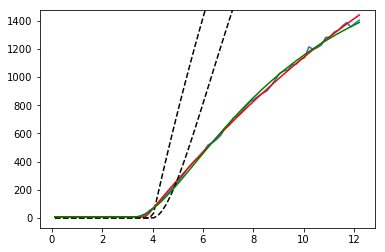

In [12]:
data = egfp[40]
sigma = np.sqrt(data)
result2 = twostage_model.fit(data, t=time, t0=4, ktl=800, delta=0.07, beta=0.05, weights=1/sigma)
result3 = threestage_model.fit(data, t=time, t0=4, ktl=800, km=1,delta=0.07, beta=0.05, weights=1/sigma)
plt.figure()
plt.plot(time,data)
plt.plot(time,result2.init_fit, 'k--')
plt.plot(time, result2.best_fit, 'r-')
plt.plot(time,result3.init_fit, 'k--')
plt.plot(time, result3.best_fit, 'g-')
plt.ylim((-0.05*data.max(),data.max()*1.05))
print(result2.fit_report())
print(result3.fit_report())

In [13]:
# cluster analysis to find the onset for fluorescence
# normalize the data
time_norm=(time-time.min())/50/(time.max()-time.min())
t0cluster_list=[]
for data in egfp:
    data_norm=(data-data.min())/(data.max()-data.min())
    data_diff_norm=np.gradient(data_norm)
    # combine the data
    X = np.vstack((time_norm,data_norm,data_diff_norm)).T
    # generate the linkage matrix
    Z = ch.linkage(X, method='single',metric='cityblock')
    tree = ch.cut_tree(Z, height=0.003).flatten()
    t0cluster_list.append(tree[tree==0].size)
t0cluster_list=np.array(t0cluster_list)
# convert to hours
t0cluster_list=(t0cluster_list)*10/60

data set 0 t0_guess 3.7538952668680765
data set 1 t0_guess 2.9628594511165773
data set 2 t0_guess 2.5421330626177023
data set 3 t0_guess 3.2951716990870676
data set 4 t0_guess 6.959645990922844
data set 5 t0_guess 4.26185019179278
data set 6 t0_guess 7.313051440174475
data set 7 t0_guess 4.253502265348645
data set 8 t0_guess 6.6793729314119865
data set 9 t0_guess 3.7742240992049814
data set 10 t0_guess 4.056696765231197
data set 11 t0_guess 4.059220689981992
data set 12 t0_guess 3.6711406659304764
data set 13 t0_guess 4.286099981061074
data set 14 t0_guess 4.166440548284171
data set 15 t0_guess 3.0801833945722943
data set 16 t0_guess 8.571707471373442
data set 17 t0_guess 4.625017490791613
data set 18 t0_guess 3.838251808768255
data set 19 t0_guess 3.554346688034188
data set 20 t0_guess 5.2487470420236635


/Users/hstrey/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


data set 21 t0_guess 3.8337658656132265
data set 22 t0_guess 4.8818524997892245
data set 23 t0_guess 5.911816799695933
data set 24 t0_guess 4.593556281407035
data set 25 t0_guess 8.154700149925038
data set 26 t0_guess 5.11149503888442
data set 27 t0_guess 3.540543259557344
data set 28 t0_guess 4.275046883538988
data set 29 t0_guess 5.257463428143225
data set 30 t0_guess 8.429243252103596
data set 31 t0_guess 2.7229287627046435
data set 32 t0_guess 5.183206734114877
data set 33 t0_guess 2.995427173763263
data set 34 t0_guess 2.5882750490417985
data set 35 t0_guess 6.177534886542896
data set 36 t0_guess 2.912286412646199
data set 37 t0_guess 4.638671998420222
data set 38 t0_guess 5.056083717630366
data set 39 t0_guess 3.809492321360579
data set 40 t0_guess 4.165451818875338
data set 41 t0_guess 3.990800267674382
data set 42 t0_guess 3.1913951680705592
data set 43 t0_guess 3.6662490055688144
data set 44 t0_guess 6.738752949241878
data set 45 t0_guess 7.5438212881022615
data set 46 t0_gues

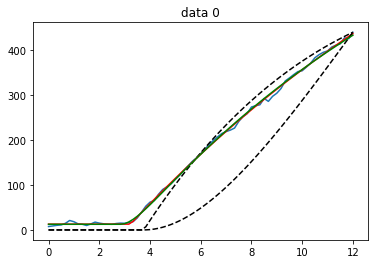

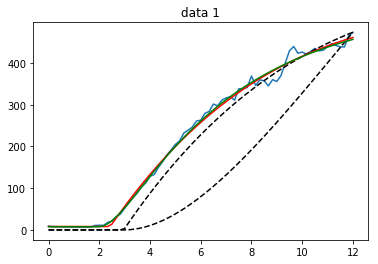

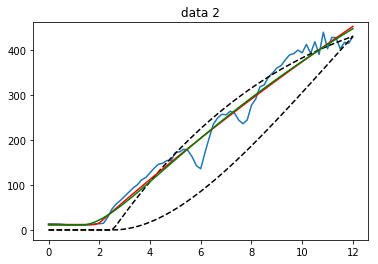

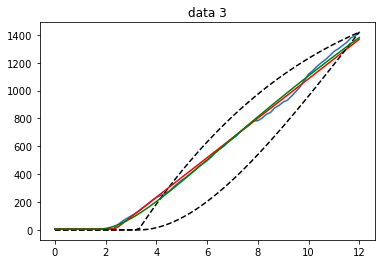

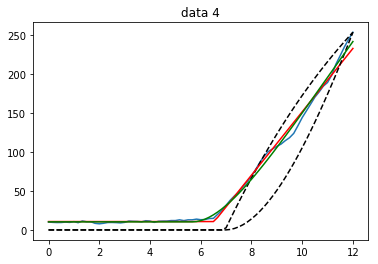

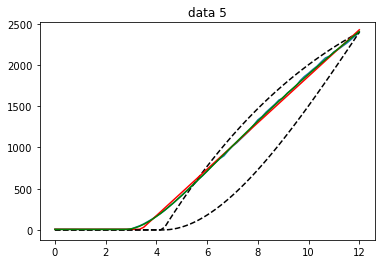

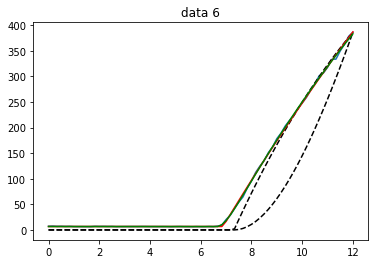

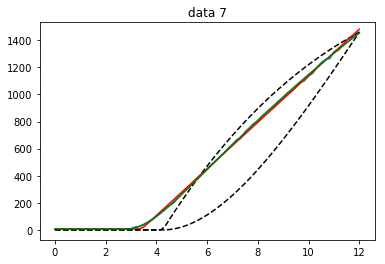

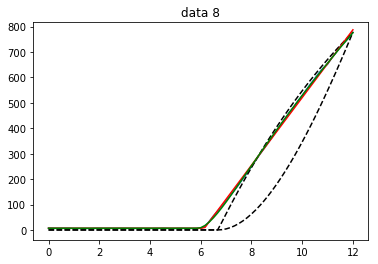

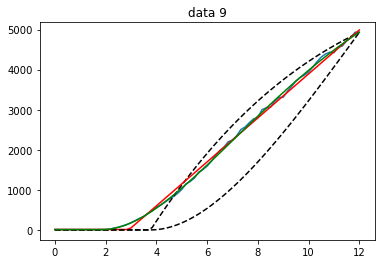

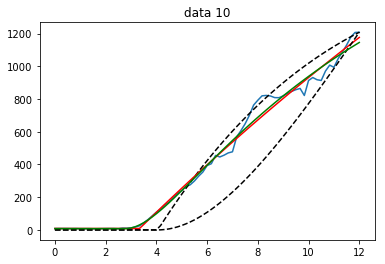

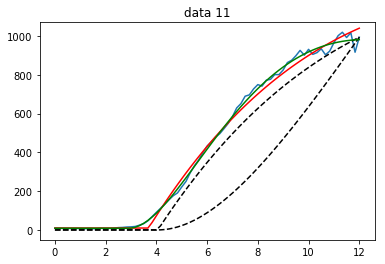

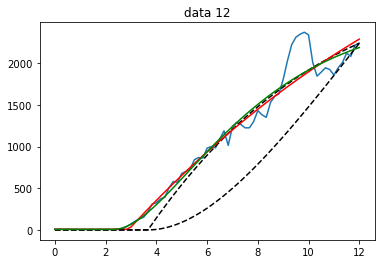

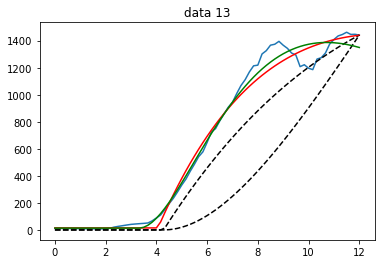

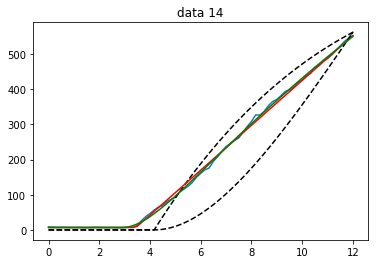

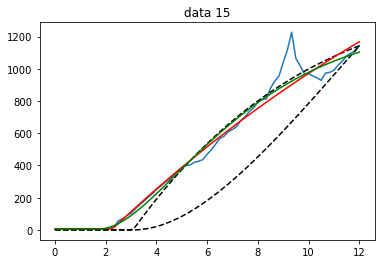

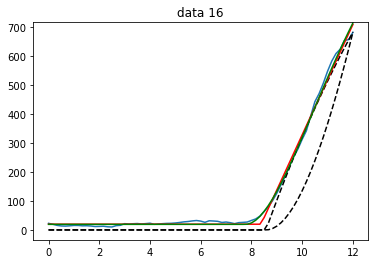

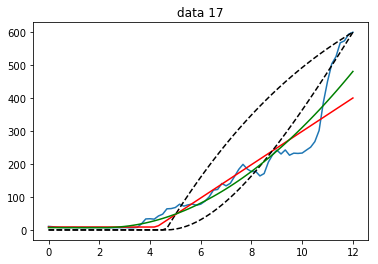

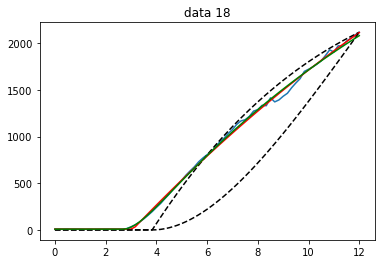

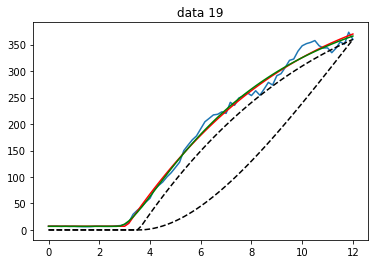

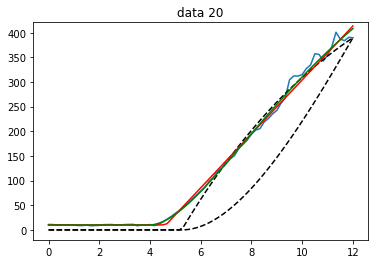

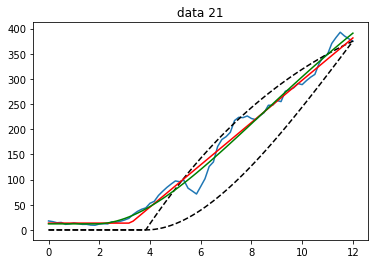

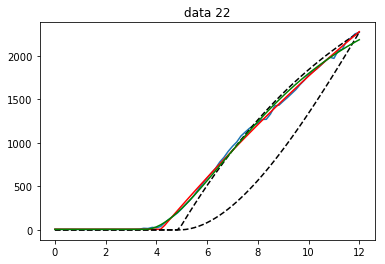

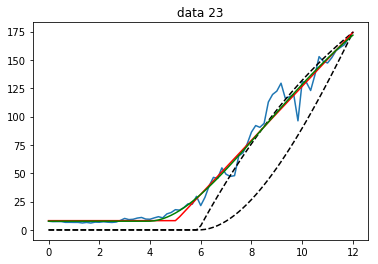

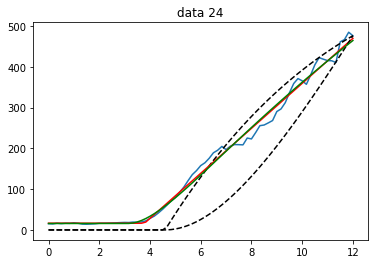

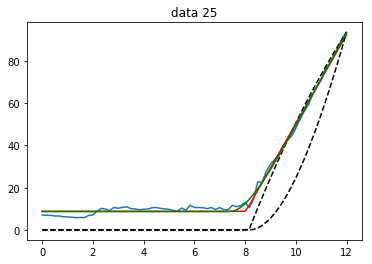

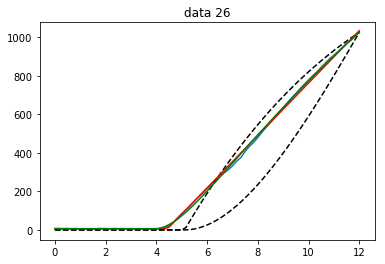

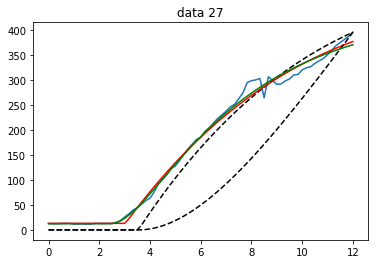

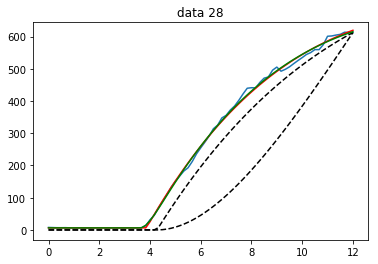

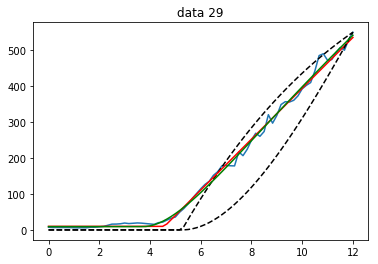

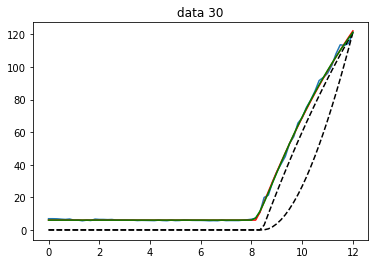

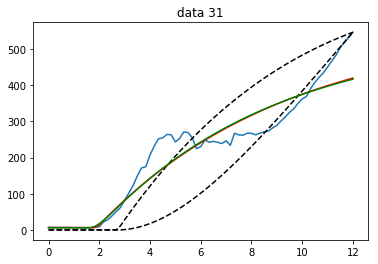

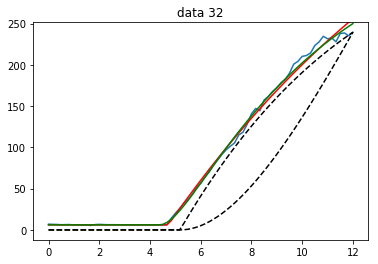

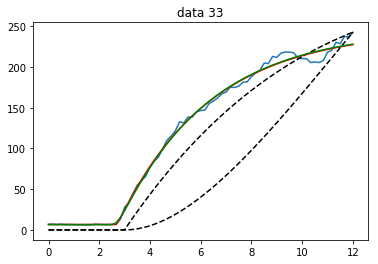

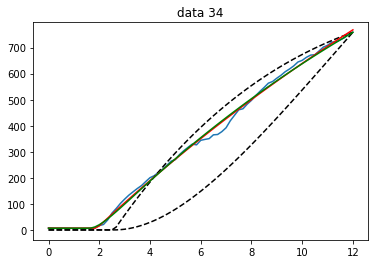

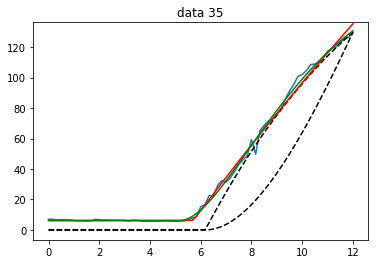

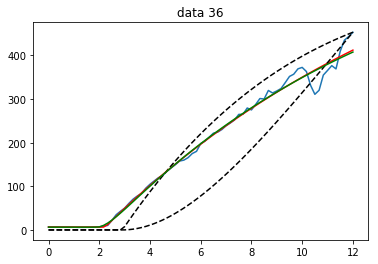

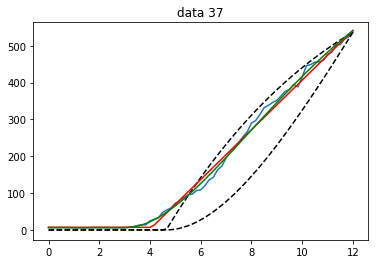

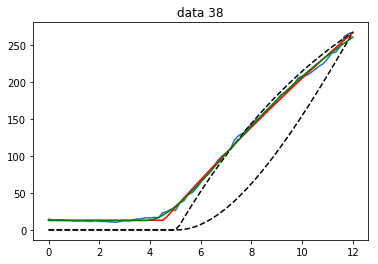

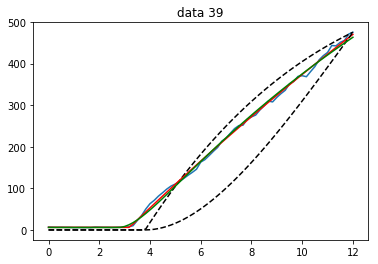

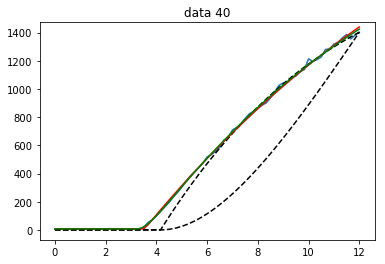

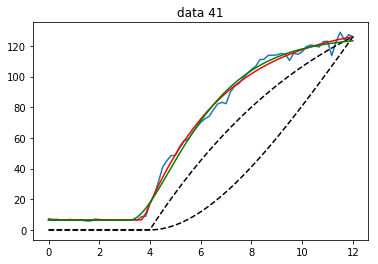

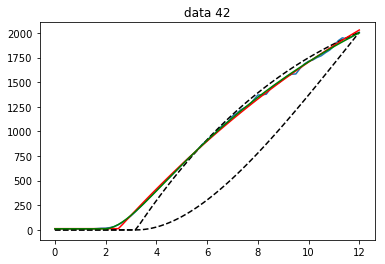

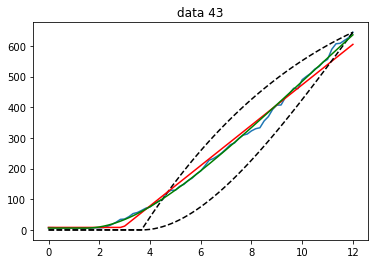

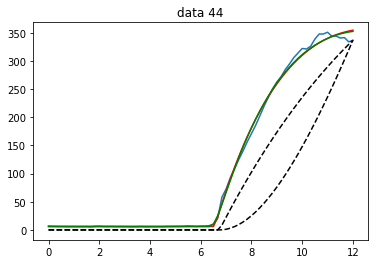

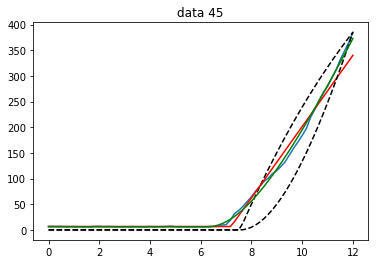

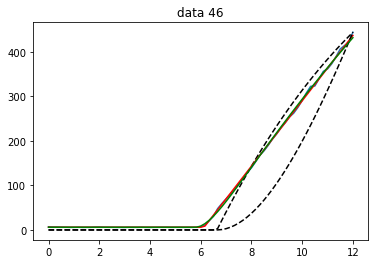

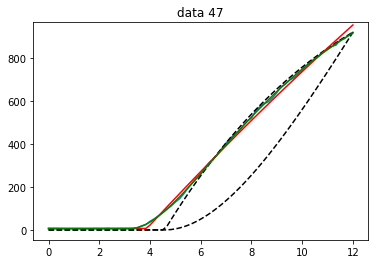

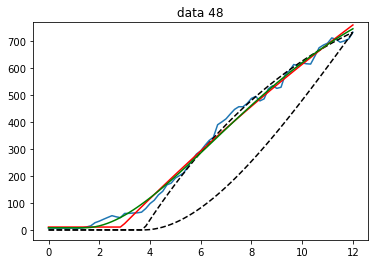

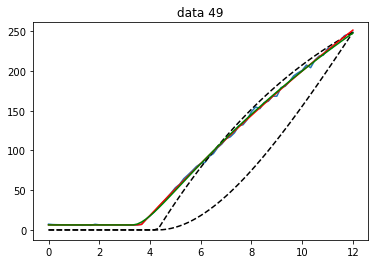

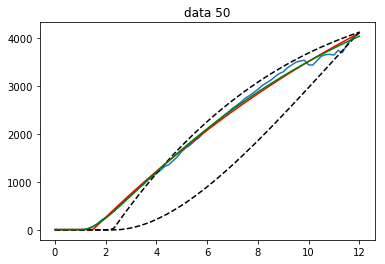

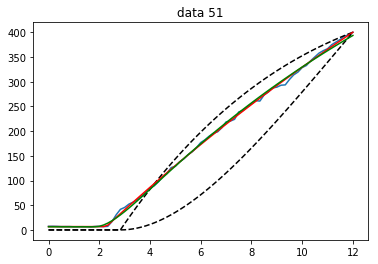

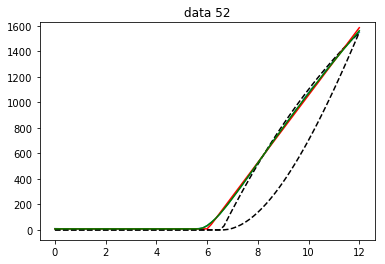

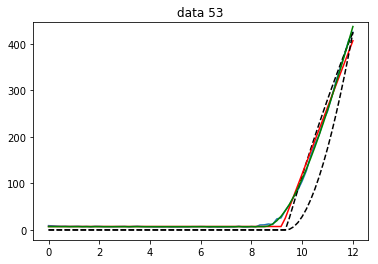

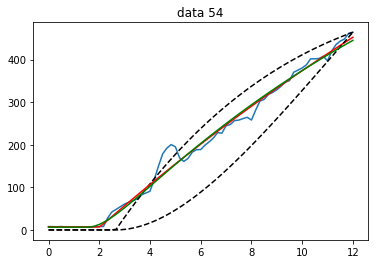

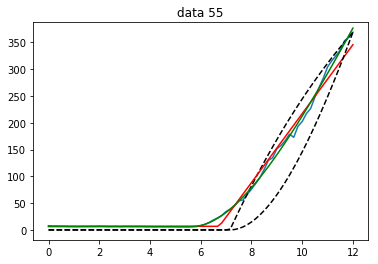

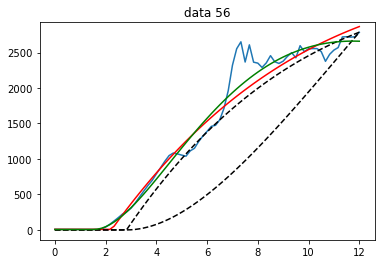

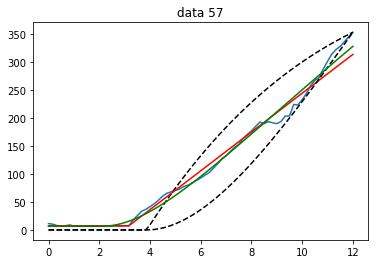

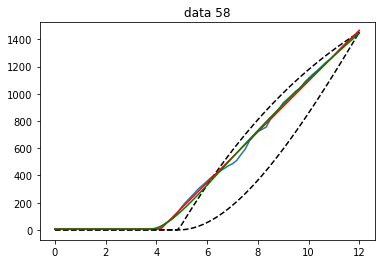

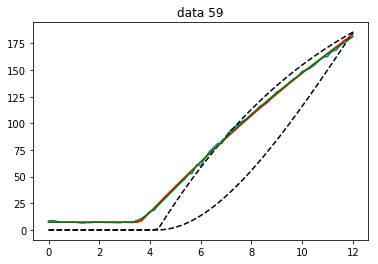

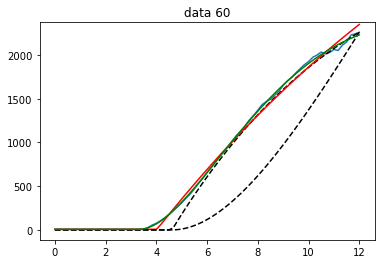

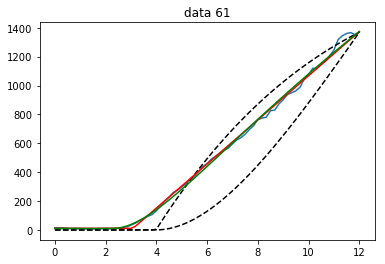

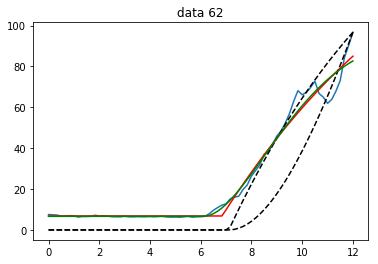

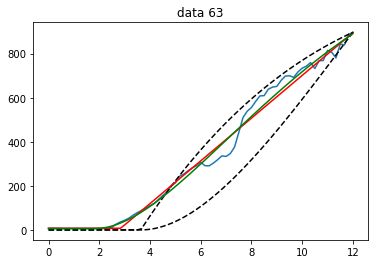

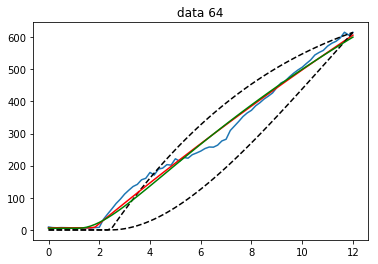

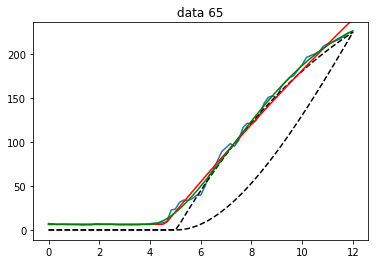

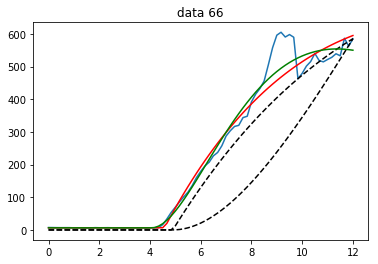

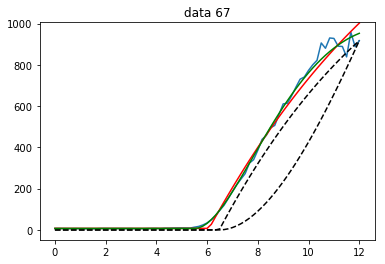

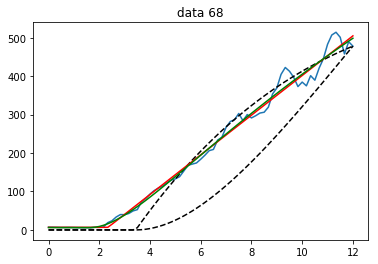

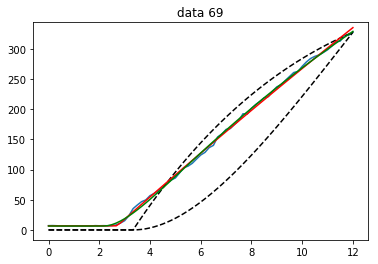

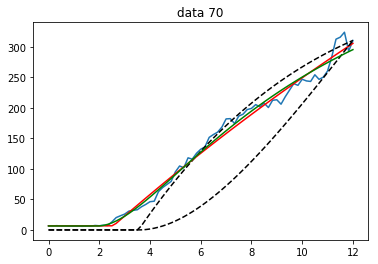

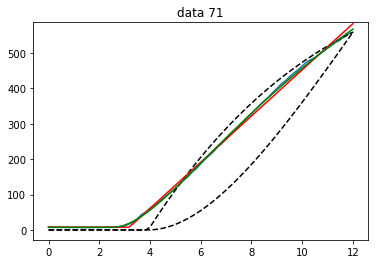

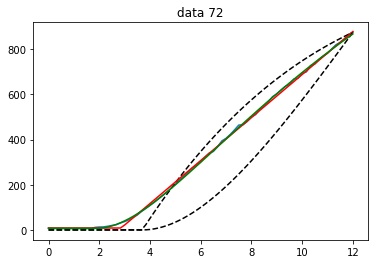

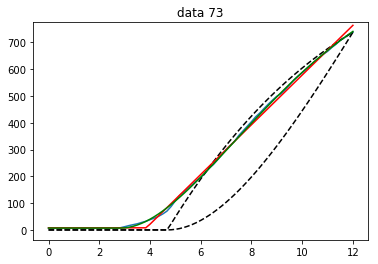

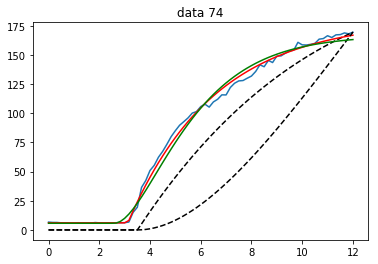

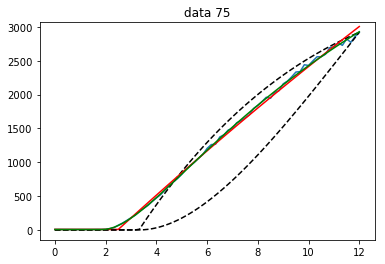

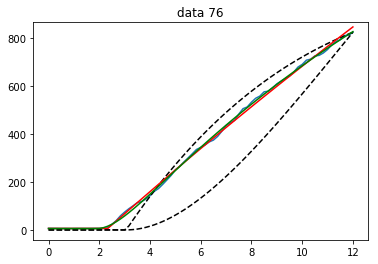

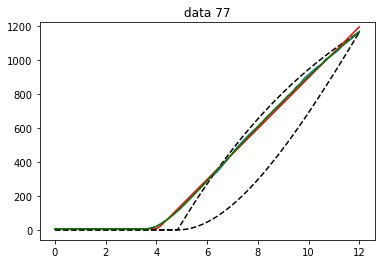

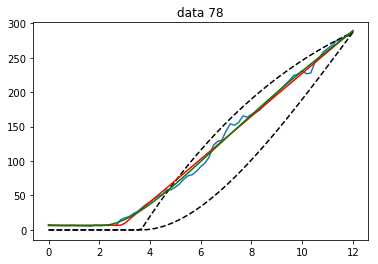

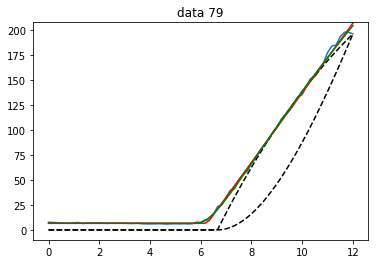

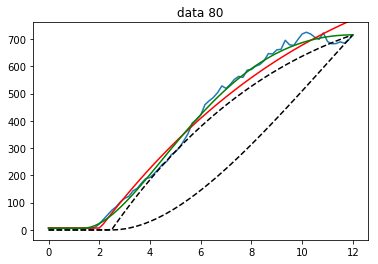

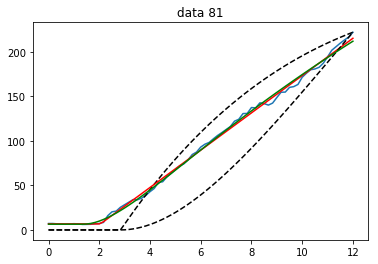

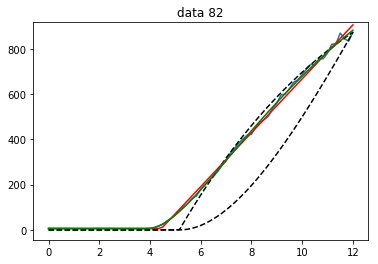

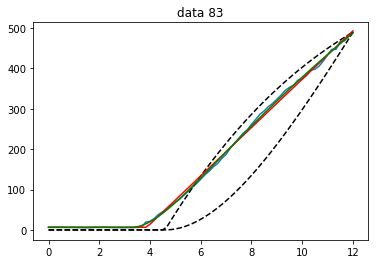

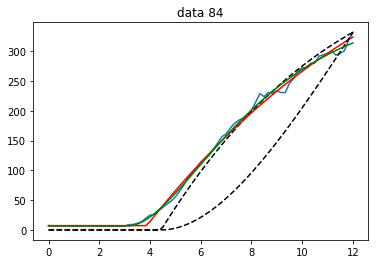

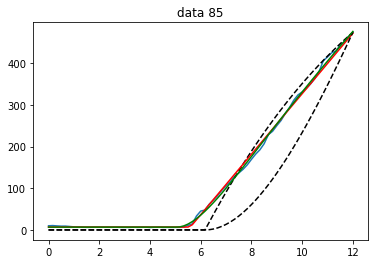

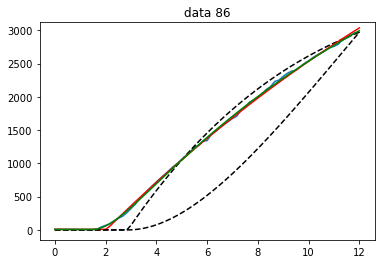

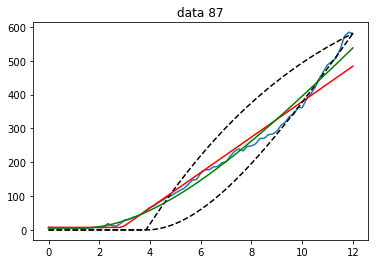

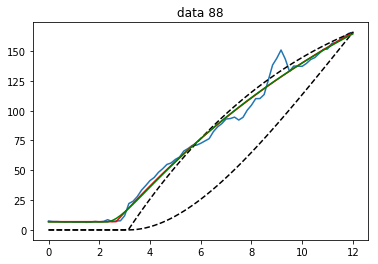

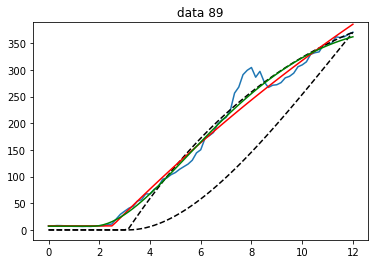

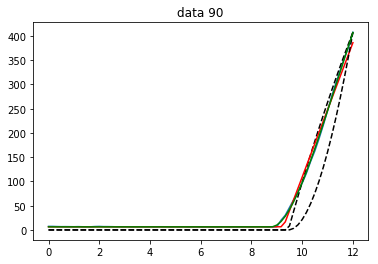

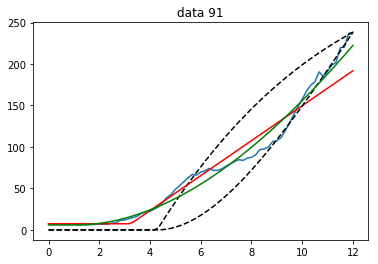

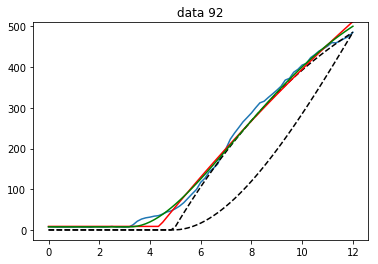

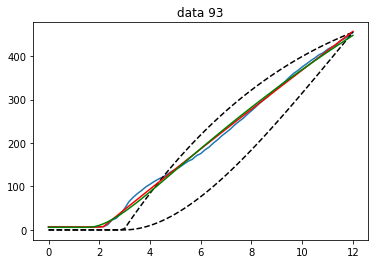

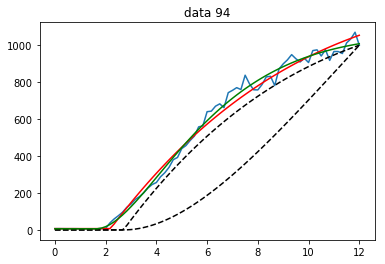

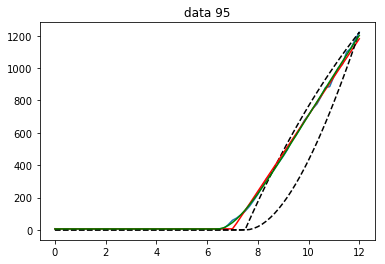

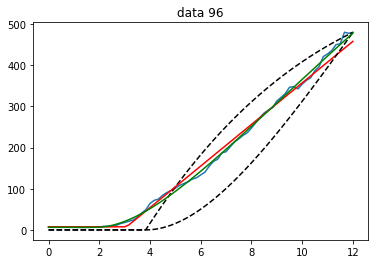

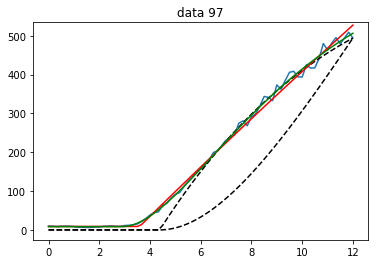

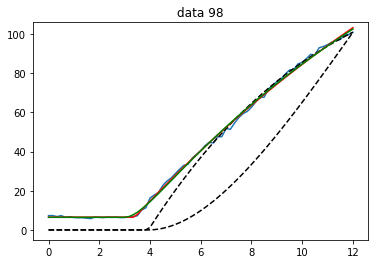

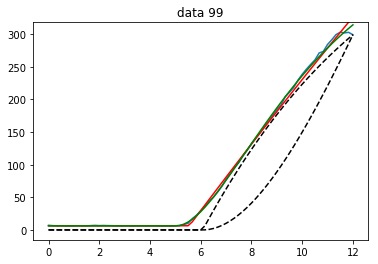

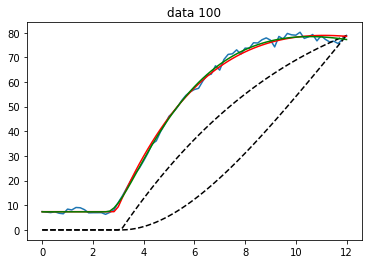

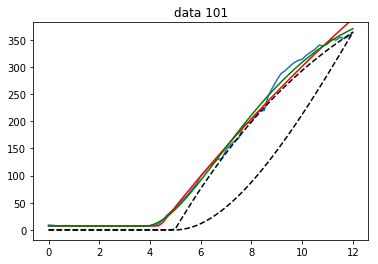

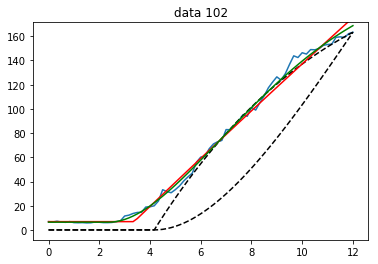

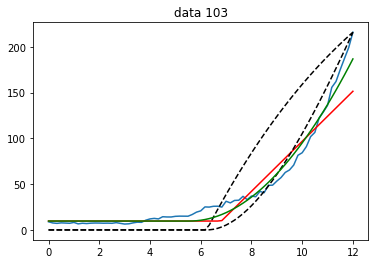

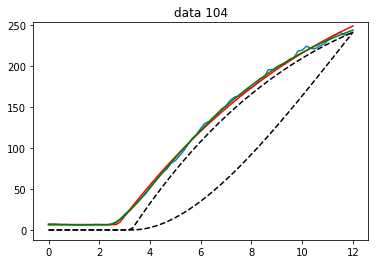

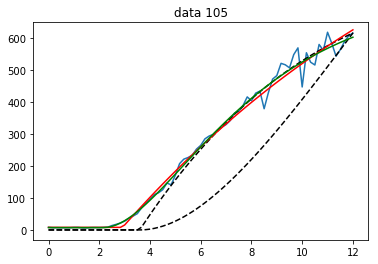

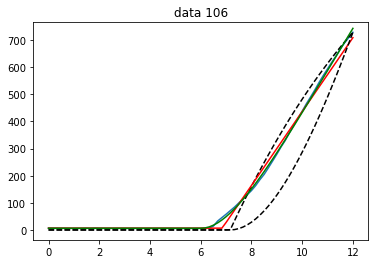

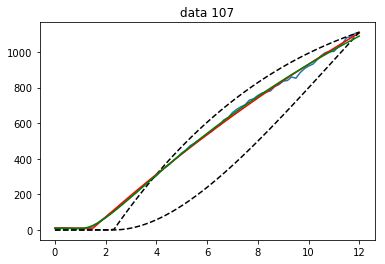

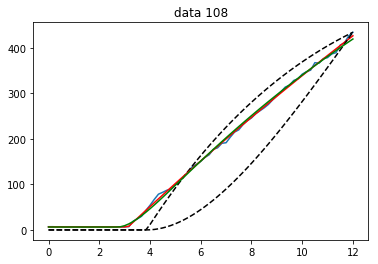

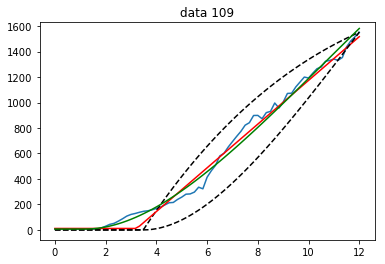

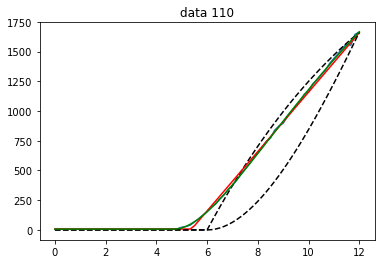

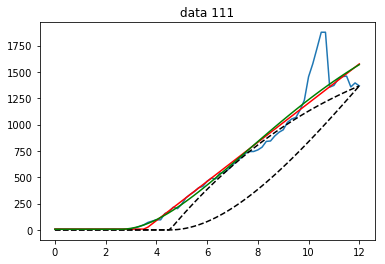

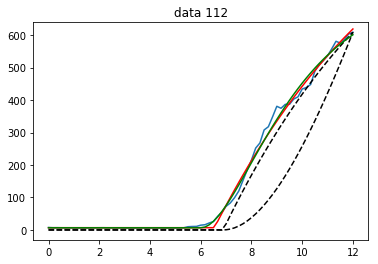

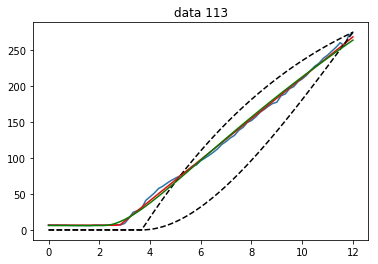

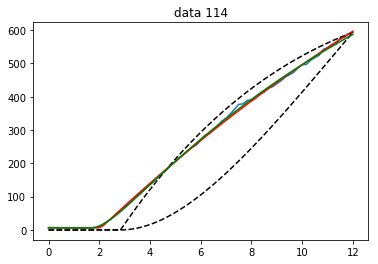

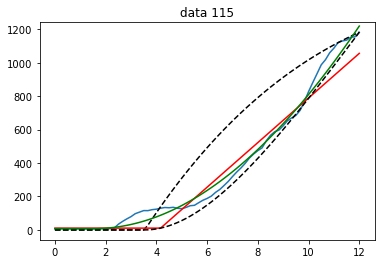

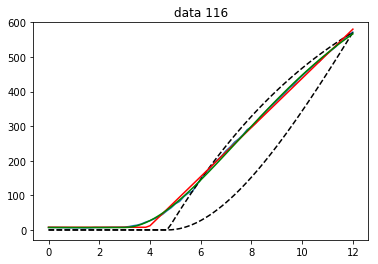

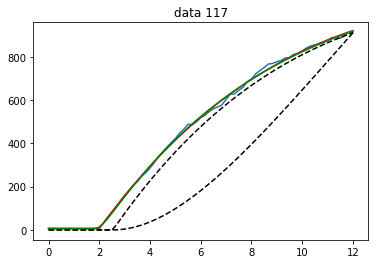

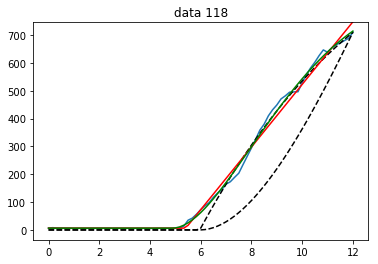

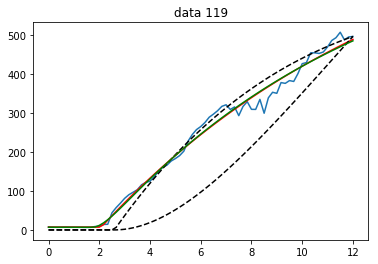

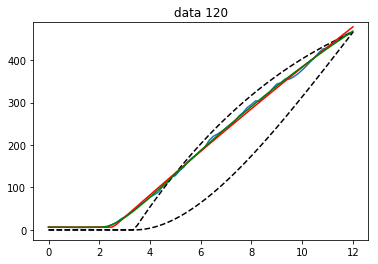

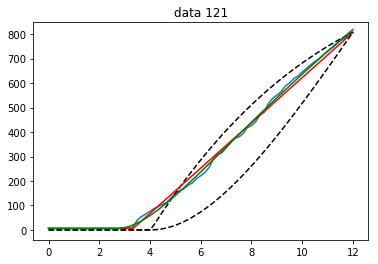

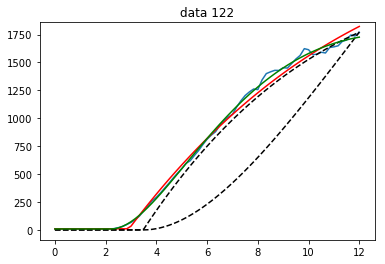

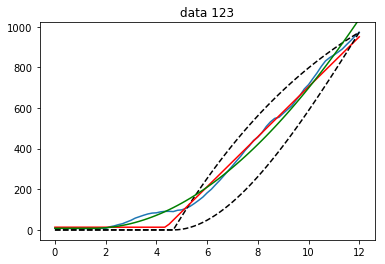

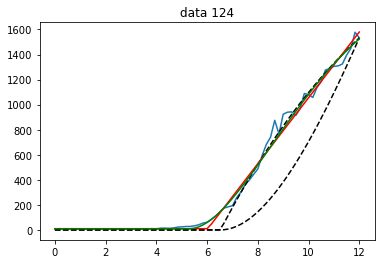

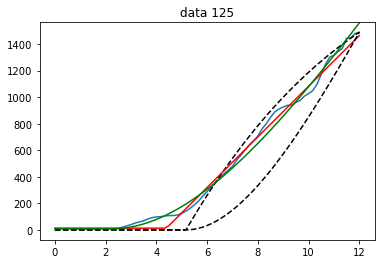

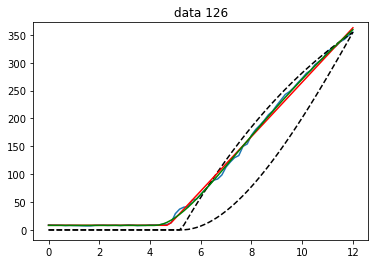

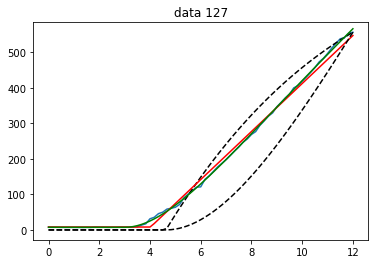

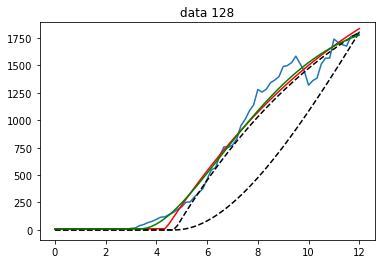

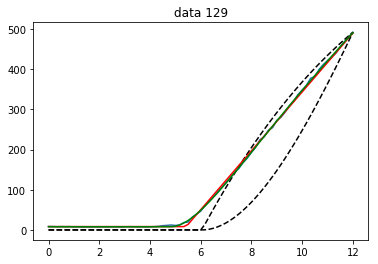

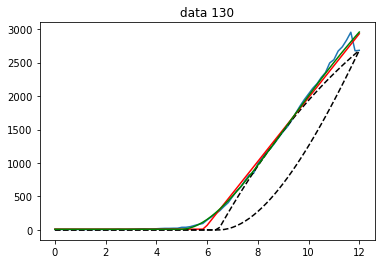

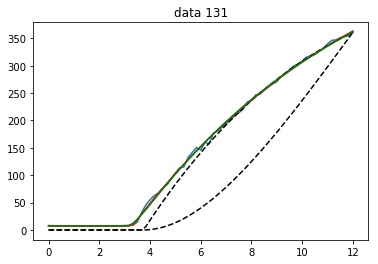

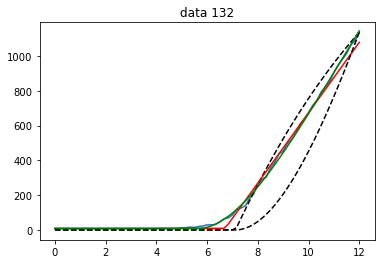

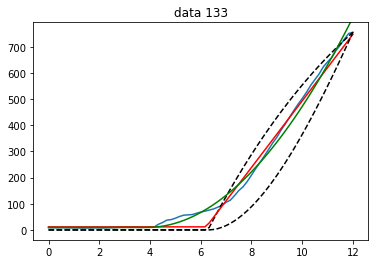

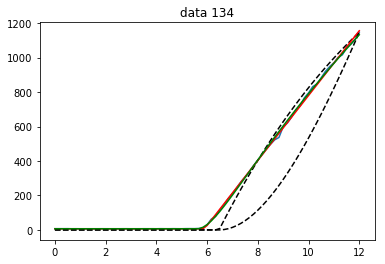

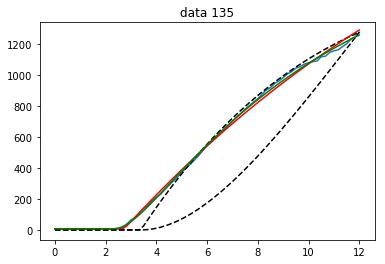

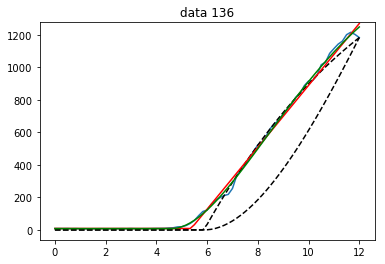

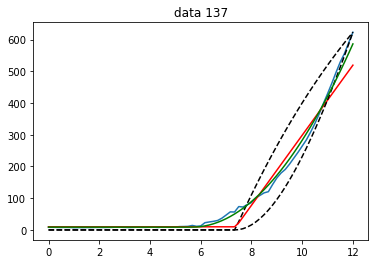

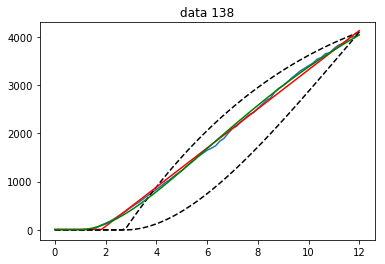

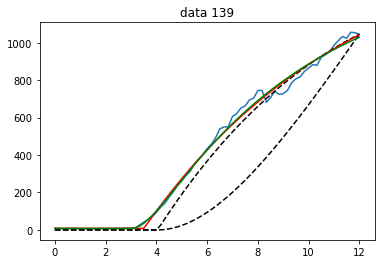

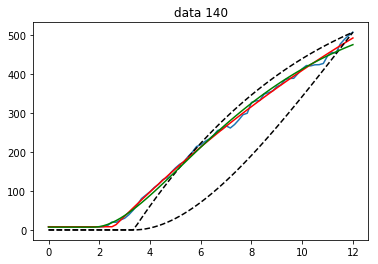

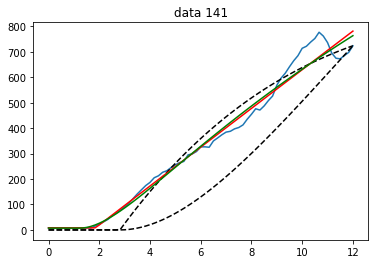

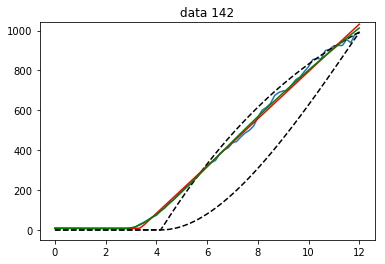

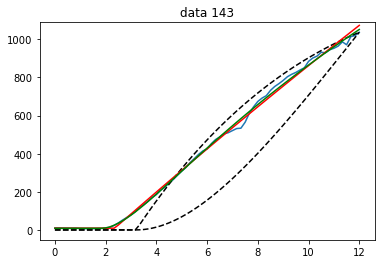

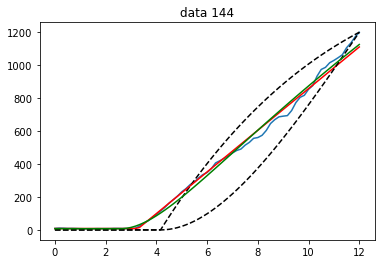

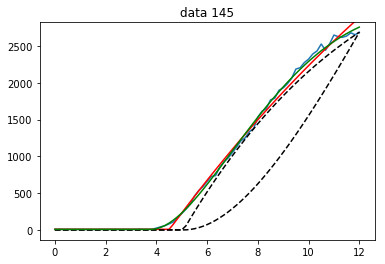

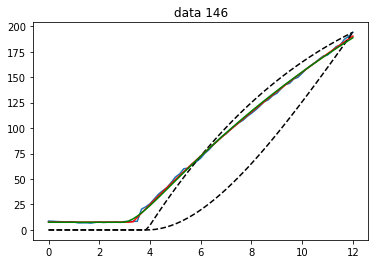

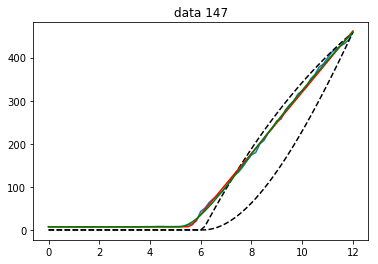

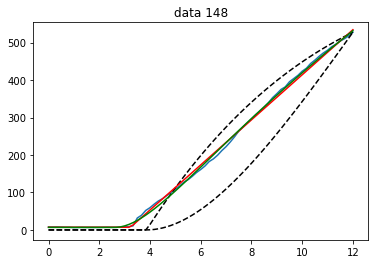

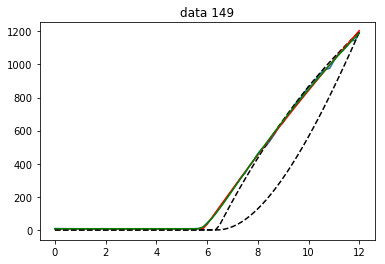

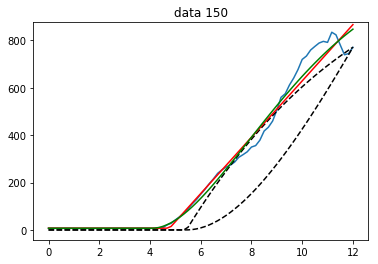

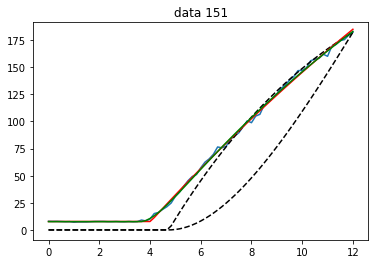

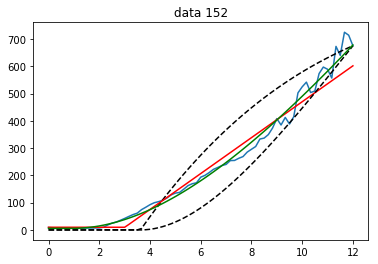

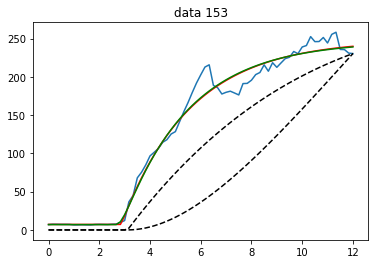

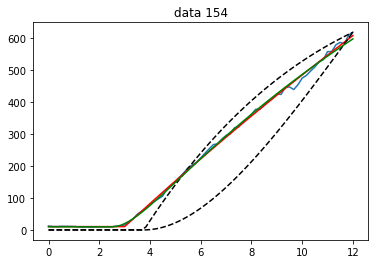

In [14]:
# two stage model
t0_list=[]
ktl_list=[]
delta_list=[]
beta_list=[]
t0_std_list=[]
ktl_std_list=[]
delta_std_list=[]
beta_std_list=[]
red_chi2_list=[]

# three stage model
t0_list3=[]
ktl_list3=[]
km_list3=[]
delta_list3=[]
beta_list3=[]
t0_std_list3=[]
ktl_std_list3=[]
km_std_list3=[]
delta_std_list3=[]
beta_std_list3=[]
red_chi2_list3=[]

for data,i in zip(egfp,range(t0cluster_list.size)):
    sigma = np.sqrt(data)
    time = np.arange(0,data.size)*10/60
    # lets estimate the parameters
    # to estimate t0 we take I_max-I_min and estimate t for which I=I_min+0.1(I_max-Imin)
    # this can be done by interpolation.  The advantage is that the guess for t0 is greater
    # than the actual value - fits seems to converge better
    delta_I=data.max()-data.min()
    t0guess = interp1d(data,time)(data.min()+0.09*delta_I)
    print("data set",i,"t0_guess",t0guess)
    delta_t=time[-1]-t0guess
    
    two=twostage(np.array([delta_t]),0,1,0.07,0.05)
    ktl2=data[-1]/two[0]
    
    three=threestage(np.array([delta_t]),0,1,0.03,0.07,0.05)
    ktl3=data[-1]/three[0]
    
    result2 = twostage_model.fit(data, t=time, t0=t0guess, ktl=ktl2, delta=0.07, beta=0.05, weights=1/sigma)
    result3 = threestage_model.fit(data, t=time, t0=t0guess, ktl=ktl3, km=0.03,delta=0.07, beta=0.05, weights=1/sigma)

    plt.figure()
    plt.title("data "+str(i))
    plt.plot(time,data)
    plt.plot(time,result2.init_fit, 'k--')
    plt.plot(time, result2.best_fit, 'r-')
    plt.plot(time,result3.init_fit, 'k--')
    plt.plot(time, result3.best_fit, 'g-')
    plt.ylim((-0.05*data.max(),data.max()*1.05))
    
    if result2:
        t0_list.append(np.abs(result2.values['t0']))
        ktl_list.append(np.abs(result2.values['ktl']))
        delta_list.append(np.abs(result2.values['delta']))
        beta_list.append(np.abs(result2.values['beta']))
        red_chi2_list.append(result2.redchi)

        t0_std_list.append(result2.covar[0][0])
        ktl_std_list.append(result2.covar[1][1])
        delta_std_list.append(result2.covar[2][2])
        beta_std_list.append(result2.covar[3][3])
    
    if result3:
        t0_list3.append(np.abs(result3.values['t0']))
        ktl_list3.append(np.abs(result3.values['ktl']))
        km_list3.append(np.abs(result3.values['km']))
        delta_list3.append(np.abs(result3.values['delta']))
        beta_list3.append(np.abs(result3.values['beta']))
        red_chi2_list3.append(result3.redchi)

        t0_std_list3.append(result3.covar[0][0])
        ktl_std_list3.append(result3.covar[1][1])
        km_std_list3.append(result3.covar[2][2])
        delta_std_list3.append(result3.covar[3][3])
        beta_std_list3.append(result3.covar[4][4])
    
t0_list=np.array(t0_list)
ktl_list=np.array(ktl_list)
delta_list=np.array(delta_list)
beta_list=np.array(beta_list)
t0_std_list=np.array(t0_std_list)
ktl_std_list=np.array(ktl_std_list)
delta_std_list=np.array(delta_std_list)
beta_std_list=np.array(beta_std_list)

t0_list3=np.array(t0_list3)
ktl_list3=np.array(ktl_list3)
km_list3=np.array(km_list3)
delta_list3=np.array(delta_list3)
beta_list3=np.array(beta_list3)
t0_std_list3=np.array(t0_std_list3)
ktl_std_list3=np.array(ktl_std_list3)
km_std_list3=np.array(km_std_list3)
delta_std_list3=np.array(delta_std_list3)
beta_std_list3=np.array(beta_std_list3)

red_chi2_list=np.array(red_chi2_list)
red_chi2_list3=np.array(red_chi2_list3)


2.09224627394 1.15676210845
3.53452130662 2.10891674422
[ 13.20722181   9.95907939   2.2043974    0.86402496   0.28597827
   0.05034129]
[ 8.08154861  5.17865717  1.03315728  0.35744753  0.17012817  0.03605222]


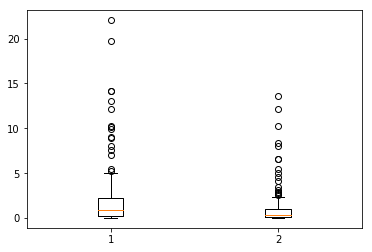

In [15]:
plt.boxplot([red_chi2_list,red_chi2_list3])
print(red_chi2_list.mean(),red_chi2_list3.mean())
print(red_chi2_list.std(),red_chi2_list3.std())
print(np.percentile(red_chi2_list,[97.5,95,75,50,25,2.5]))
print(np.percentile(red_chi2_list3,[97.5,95,75,50,25,2.5]))

In [16]:
print(np.argmax(red_chi2_list),red_chi2_list.max())
print(np.argmax(red_chi2_list3),red_chi2_list3.max())

115 22.0326315417
56 13.6515203617


In [17]:
# cleaning up the data by setting a threshold for redchi2
threshold2 = 150
threshold3 = 150
ktl_list_clean=ktl_list[red_chi2_list<threshold2]
delta_list_clean=delta_list[red_chi2_list<threshold2]
beta_list_clean=beta_list[red_chi2_list<threshold2]
t0_list_clean=t0_list[red_chi2_list<threshold2]
ktl_std_list_clean=ktl_std_list[red_chi2_list<threshold2]
delta_std_list_clean=delta_std_list[red_chi2_list<threshold2]
beta_std_list_clean=beta_std_list[red_chi2_list<threshold2]
t0_std_list_clean=t0_std_list[red_chi2_list<threshold2]

ktl_list3_clean=ktl_list3[red_chi2_list3<threshold3]
km_list3_clean=km_list3[red_chi2_list3<threshold3]
delta_list3_clean=delta_list3[red_chi2_list3<threshold3]
beta_list3_clean=beta_list3[red_chi2_list3<threshold3]
t0_list3_clean=t0_list3[red_chi2_list3<threshold3]
km_std_list3_clean=km_std_list3[red_chi2_list3<threshold3]
ktl_std_list3_clean=ktl_std_list3[red_chi2_list3<threshold3]
delta_std_list3_clean=delta_std_list3[red_chi2_list3<threshold3]
beta_std_list3_clean=beta_std_list3[red_chi2_list3<threshold3]
t0_std_list3_clean=t0_std_list3[red_chi2_list3<threshold3]


In [18]:
print(ktl_list.size,ktl_list_clean.size)
print(ktl_list3.size,ktl_list3_clean.size)

155 155
155 155


125.680537976 10301.6414131


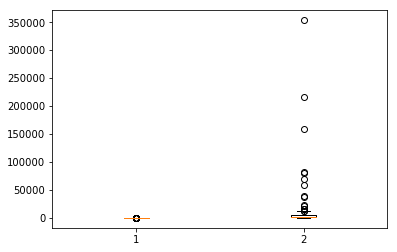

In [19]:
plt.boxplot([ktl_list_clean,ktl_list3_clean])
print(ktl_list_clean.mean(),ktl_list3_clean.mean())

(array([ 146.,    4.,    2.,    0.,    1.,    0.,    1.,    0.,    0.,    1.]),
 array([  1.34921024e+02,   3.54646778e+04,   7.07944346e+04,
          1.06124191e+05,   1.41453948e+05,   1.76783705e+05,
          2.12113462e+05,   2.47443218e+05,   2.82772975e+05,
          3.18102732e+05,   3.53432489e+05]),
 <a list of 10 Patch objects>)

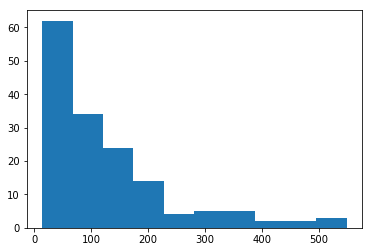

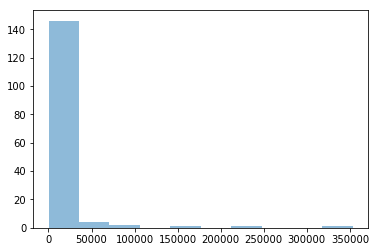

In [20]:
plt.figure()
plt.hist(ktl_list_clean)
plt.figure()
plt.hist(ktl_list3_clean,alpha=0.5)

(array([ 76.,  53.,  11.,   4.,   4.,   2.,   0.,   1.,   1.,   3.]),
 array([ 0.0023587 ,  0.04178486,  0.08121103,  0.12063719,  0.16006336,
         0.19948952,  0.23891568,  0.27834185,  0.31776801,  0.35719418,
         0.39662034]),
 <a list of 10 Patch objects>)

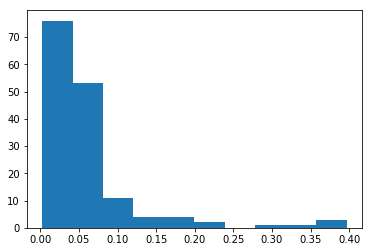

In [21]:
plt.figure()
plt.hist(km_list3_clean)

{'boxes': [<matplotlib.lines.Line2D at 0x120632780>,
 'caps': [<matplotlib.lines.Line2D at 0x120639b38>,
 'fliers': [<matplotlib.lines.Line2D at 0x1206a1a90>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x12069cba8>,
 'whiskers': [<matplotlib.lines.Line2D at 0x1206329e8>,
  <matplotlib.lines.Line2D at 0x1206a7c50>]}

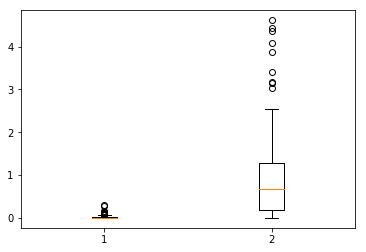

In [22]:
plt.boxplot([delta_list_clean,delta_list3_clean])

0.0235428939357 0.902550509186


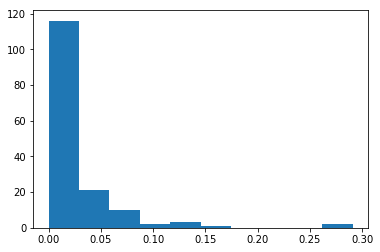

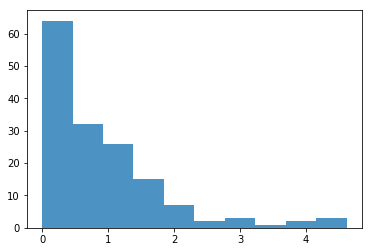

In [23]:
plt.figure()
plt.hist(delta_list_clean)
plt.figure()
plt.hist(delta_list3_clean,alpha=0.8)
print(delta_list_clean.mean(),delta_list3_clean.mean())

{'boxes': [<matplotlib.lines.Line2D at 0x120b5edd8>,
 'caps': [<matplotlib.lines.Line2D at 0x120b6a860>,
 'fliers': [<matplotlib.lines.Line2D at 0x120b6fa58>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x120b6f240>,
 'whiskers': [<matplotlib.lines.Line2D at 0x120b5ef60>,
  <matplotlib.lines.Line2D at 0x120b7d978>]}

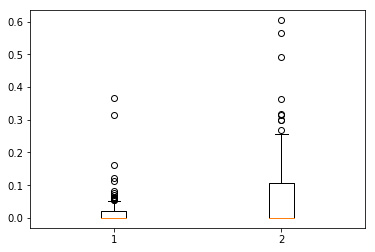

In [24]:
plt.boxplot([beta_list_clean,beta_list3_clean])

(array([ 106.,   18.,   14.,    6.,    5.,    2.,    1.,    0.,    1.,    2.]),
 array([  7.33090752e-09,   6.04019953e-02,   1.20803983e-01,
          1.81205971e-01,   2.41607959e-01,   3.02009947e-01,
          3.62411935e-01,   4.22813923e-01,   4.83215911e-01,
          5.43617899e-01,   6.04019887e-01]),
 <a list of 10 Patch objects>)

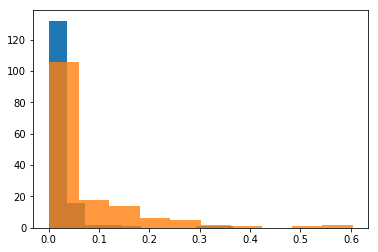

In [25]:
plt.hist(beta_list_clean)
plt.hist(beta_list3_clean,alpha=0.8)

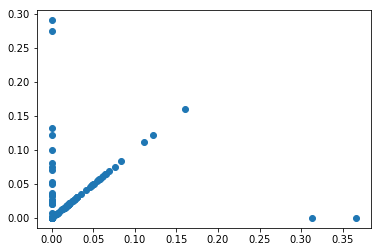

In [26]:
plt.plot(beta_list_clean,delta_list_clean,"o")

{'boxes': [<matplotlib.lines.Line2D at 0x120f3ff98>],
 'caps': [<matplotlib.lines.Line2D at 0x120f4ca20>,
 'fliers': [<matplotlib.lines.Line2D at 0x120f51c18>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x120f51400>],
 'whiskers': [<matplotlib.lines.Line2D at 0x120f479b0>,
  <matplotlib.lines.Line2D at 0x120f47b38>]}

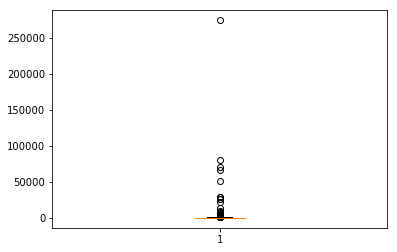

In [27]:
error_delta = delta_std_list_clean/delta_list_clean
plt.boxplot(error_delta)

{'boxes': [<matplotlib.lines.Line2D at 0x121017128>,
 'caps': [<matplotlib.lines.Line2D at 0x12101db70>,
 'fliers': [<matplotlib.lines.Line2D at 0x121023d68>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x121023550>,
 'whiskers': [<matplotlib.lines.Line2D at 0x121017b00>,
  <matplotlib.lines.Line2D at 0x12103ff28>]}

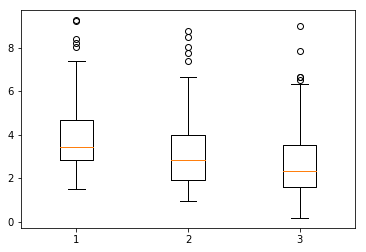

In [28]:
plt.boxplot([t0_list_clean,t0_list3_clean,t0cluster_list])

3.96668080292
3.24721702956
2.62795698925


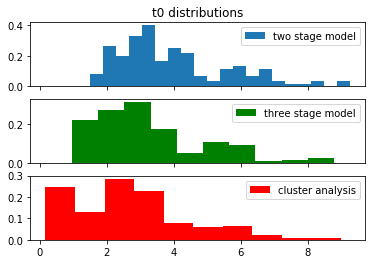

In [29]:
plt.figure()
# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(3, sharex=True)
axarr[0].hist(t0_list_clean, bins=20,normed=True,label='two stage model')
axarr[0].set_title('t0 distributions')
axarr[0].legend()
axarr[1].hist(t0_list3_clean,bins=10,color='g',normed=True,label='three stage model')
axarr[1].legend()
axarr[2].hist(t0cluster_list,bins=10,color='r',normed=True,label='cluster analysis')
axarr[2].legend()
print(t0_list_clean.mean())
print(t0_list3_clean.mean())
print(t0cluster_list.mean())

In [30]:
# save data
np.save("k5_t0_two",t0_list_clean)
np.save("k5_t0_three",t0_list3_clean)
np.save("k5_t0_cluster",t0cluster_list)

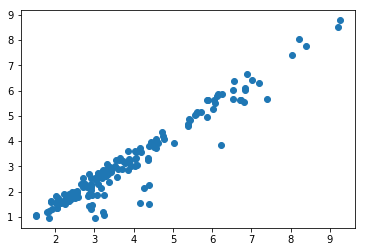

In [31]:
plt.plot(t0_list_clean,t0_list3_clean,"o")